**Installations**

In [0]:
!pip install --upgrade keras==2.3.1
!pip install --upgrade tensorflow==1.15

Requirement already up-to-date: keras==2.3.1 in /usr/local/lib/python3.6/dist-packages (2.3.1)
Requirement already up-to-date: tensorflow==1.15 in /usr/local/lib/python3.6/dist-packages (1.15.0)


**Imports**

In [0]:
import os, datetime, argparse, csv, itertools, random
from sys import exit
import nltk, tensorflow

import pandas as pd
import numpy as np

from math import exp
import re
from re import sub
from time import time
from random import shuffle

from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split as split_data

import keras
import keras.backend as K

from keras import regularizers
from keras.models import Model, load_model
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
from keras.activations import softmax
from keras.optimizers import Adadelta, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib
import matplotlib.pyplot as plt
import tkinter

matplotlib.use('TkAgg')

from google.colab import drive
from oauth2client.client import GoogleCredentials

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Data Parsing**

In [0]:
# data_file = '/content/gdrive/My Drive/Colab Notebooks/imdb-spoiler-dataset/movie_training_data.csv'
# data_file = '/content/gdrive/My Drive/Colab Notebooks/imdb-spoiler-dataset/movie_training_data_sumry.csv'
# data_file = '/content/gdrive/My Drive/Colab Notebooks/imdb-spoiler-dataset/movie_training_data_combo.csv'
data_file         = '/content/gdrive/My Drive/Colab Notebooks/imdb-spoiler-dataset/movie_training_data_synps.csv'
google_embeddings = '/content/gdrive/My Drive/Colab Notebooks/imdb-spoiler-dataset/GoogleNews-vectors-negative300.bin.gz'

rows_count  = 300000
train_ratio = 0.8 # divide into train and validation data
test_ratio  = 0.96 # divide into train and test data
max_len     = 30
vocab_size  = 1
vocab_limit = None

data_name     = 'movie_traning'
sequence_cols = ['sentence_1', 'sentence_2']
score_col     = ['label']

x_train, y_train  = list(), list()
x_val, y_val      = list(), list()
x_test, y_test    = list(), list()

vocab       = set('PAD')
word_to_id  = {'PAD':0}
id_to_word  = {0:'PAD'}

word_to_count = dict()

**Read Data from File**

In [0]:
print('Loading data from file')
data_df = pd.read_csv(data_file, nrows=rows_count)
data_df.head()

Loading data from file


,movie_id,sentence_1,sentence_2,label
0,tt1568346,Note: this is an English-language adaptation o...,"Confusing, unless you have read the book first...",True
1,tt2404435,In this remake of the 1960 film of the same na...,There Were Seven - They Weren't Magnificent Th...,True
2,tt0408236,"Benjamin Barker (Johnny Depp), a skilled barbe...",this movie gave me chills... This movie made m...,True
3,tt3498820,"In 1991, Bucky Barnes (Sebastian Stan), brainw...",One of the best Marvel movies This movie helps...,True
4,tt0109830,The film begins with a feather falling to the ...,Life through a different view! This is a lovel...,True


**Convert text to word list**

In [0]:
def text_to_word_list(text):
  ''' Pre process and convert texts to a list of words '''
  text = str(text)
  text = text.lower()

# Clean the text
  text = sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
  text = sub(r"what's", "what is ", text)
  text = sub(r"\'s", " ", text)
  text = sub(r"\'ve", " have ", text)
  text = sub(r"can't", "cannot ", text)
  text = sub(r"n't", " not ", text)
  text = sub(r"i'm", "i am ", text)
  text = sub(r"\'re", " are ", text)
  text = sub(r"\'d", " would ", text)
  text = sub(r"\'ll", " will ", text)
  text = sub(r",", " ", text)
  text = sub(r"\.", " ", text)
  text = sub(r"!", " ! ", text)
  text = sub(r"\/", " ", text)
  text = sub(r"\^", " ^ ", text)
  text = sub(r"\+", " + ", text)
  text = sub(r"\-", " - ", text)
  text = sub(r"\=", " = ", text)
  text = sub(r"'", " ", text)
  text = sub(r"(\d+)(k)", r"\g<1>000", text)
  text = sub(r":", " : ", text)
  text = sub(r" e g ", " eg ", text)
  text = sub(r" b g ", " bg ", text)
  text = sub(r" u s ", " american ", text)
  text = sub(r"\0s", "0", text)
  text = sub(r" 9 11 ", "911", text)
  text = sub(r"e - mail", "email", text)
  text = sub(r"j k", "jk", text)
  text = sub(r"\s{2,}", " ", text)

  text = text.split()
  return text

**Vocab Generation**

In [0]:
def generate_vocab():
  print('Generating vocabulary')

  global vocab_size, vocab
  global word_to_id, id_to_word, word_to_count
  global data_df

  stops = set(stopwords.words('english'))

  # Iterate over required sequences of provided dataset
  for index, row in data_df.iterrows():
      # Iterate through the text of both questions of the row
      for col in sequence_cols:
          s2n = []  # Sequences with words replaces with indices
          for word in text_to_word_list(row[col]):
              # Remove unwanted words
              if word in stops:
                  continue

              if word not in vocab:
                  vocab.add(word)
                  word_to_id[word] = vocab_size
                  word_to_count[word] = 1
                  s2n.append(vocab_size)
                  id_to_word[vocab_size] = word
                  vocab_size += 1

              else:
                  word_to_count[word] += 1
                  s2n.append(word_to_id[word])

          # Replace |sequence as word| with |sequence as number| representation
          data_df.at[index, col] = s2n

In [0]:
generate_vocab()
print('data size: ' + str(len(data_df)))

Generating vocabulary
data size: 300000


In [0]:
data_df.head()

,movie_id,sentence_1,sentence_2,label
0,tt1568346,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[625, 626, 627, 266, 248, 628, 629, 630, 631, ...",True
1,tt2404435,"[833, 834, 650, 835, 836, 430, 837, 838, 839, ...","[1057, 4, 1198, 1199, 1200, 893, 1198, 1201, 1...",True
2,tt0408236,"[1234, 1235, 1236, 1237, 1238, 1239, 1240, 124...","[1199, 1486, 1487, 1199, 1488, 1489, 1490, 149...",True
3,tt3498820,"[1581, 1582, 1583, 1584, 1585, 1586, 1587, 158...","[215, 100, 2021, 2022, 1199, 2023, 387, 2024, ...",True
4,tt0109830,"[650, 234, 2062, 1144, 2063, 2064, 2065, 1816,...","[60, 269, 2183, 1547, 2184, 1555, 4, 2185, 675...",True


**Additional Data Pre-processing**

In [0]:
def preprocess_data():
  print('Building training data set')
  
  global x_train, x_val, y_train, y_val
  global x_test, y_test

  data_size = len(data_df)  

  X = data_df[sequence_cols]
  Y = data_df[score_col]
  print(X.shape[0], Y.shape[0])
  x_rem, x_test, y_rem, y_test = split_data(X, Y, train_size=test_ratio, stratify=Y)
  x_train, x_val, y_train, y_val = split_data(x_rem, y_rem, train_size=train_ratio, stratify=y_rem)

  # Split to lists
  x_train = [x_train[column] for column in sequence_cols]
  x_val = [x_val[column] for column in sequence_cols]
  x_test = [x_test[column] for column in sequence_cols]

  # Convert labels to their numpy representations
  y_train = y_train.values
  y_val = y_val.values
  y_test = y_test.values

In [0]:
preprocess_data()
print('Length X_train: ' + str(len(x_train[0])))
print('Length X_val: ' + str(len(x_val[0])))
print('Length X_test: ' + str(len(x_test[0])))

Building training data set
300000 300000
Length X_train: 230400
Length X_val: 57600
Length X_test: 12000


**Padding sequences**

In [0]:
def pad_seq():
  print('Padding sequences')

  global max_len

  if max_len == 0:
      max_len = max(
          max(len(seq) for seq in x_train[0]),
          max(len(seq) for seq in x_train[1]),
          max(len(seq) for seq in x_val[0]),
          max(len(seq) for seq in x_val[1]),
          max(len(seq) for seq in x_test[0]),
          max(len(seq) for seq in x_test[1]))
      
  # Zero padding
  for dataset, side in itertools.product([x_train, x_val, x_test], [0, 1]):
      if max_len: dataset[side] = pad_sequences(dataset[side], maxlen=max_len)
      else : dataset[side] = pad_sequences(dataset[side])

In [0]:
pad_seq()

Padding sequences


**Embedding google news vectors**

In [0]:
embedding_size = 300 # Dimensionality of Google News' Word2Vec

In [0]:
def get_embedding_matrix(word_index):
  word2vec = KeyedVectors.load_word2vec_format(google_embeddings, binary=True)

  # Prepare Embedding Matrix.
  embedding_matrix = np.zeros((len(word_index)+1, embedding_size))

  for word, i in word_index.items():
  # words not found in embedding index will be all-zeros.
    if word not in word2vec.vocab:
      continue
    embedding_matrix[i] = word2vec.word_vec(word)

  del word2vec
  return embedding_matrix

**Build Embedding**

In [0]:
print('Building Embedding Matrix')
embedding_matrix = get_embedding_matrix(word_to_id)
embedding_size = embedding_matrix.shape[1]

Building Embedding Matrix


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# ESIM Model

In [0]:
print('\n')
print('Number of training samples   :', len(x_train[0]))
print('Number of validation samples :', len(x_val[0]))
print('Maximum sequence length      :', max_len)
print('\n')



Number of training samples   : 230400
Number of validation samples : 57600
Maximum sequence length      : 30




In [0]:
print(embedding_matrix.shape)
print(vocab_size+1)

(237582, 300)
237582


In [0]:
!pip show tensorflow
!pip show keras

Name: tensorflow
Version: 1.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: termcolor, six, keras-applications, protobuf, astor, absl-py, tensorflow-estimator, google-pasta, wheel, keras-preprocessing, numpy, wrapt, opt-einsum, tensorboard, gast, grpcio
Required-by: fancyimpute
Name: Keras
Version: 2.3.1
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, pyyaml, scipy, six, keras-applications, h5py, keras-preprocessing
Required-by: textgenrnn, keras-vis, kapre, fancyimpute


**Model Definition**

In [0]:
## ESIM
def StaticEmbedding(embedding_matrix):
    in_dim, out_dim = embedding_matrix.shape
    return Embedding(in_dim, out_dim, weights=[embedding_matrix], trainable=False)

def subtract(input_1, input_2):
    minus_input_2 = Lambda(lambda x: -x)(input_2)
    return add([input_1, minus_input_2])

def aggregate(input_1, input_2, num_dense=300, dropout_rate=0.5):
    feat1 = concatenate([GlobalAvgPool1D()(input_1), GlobalMaxPool1D()(input_1)])
    feat2 = concatenate([GlobalAvgPool1D()(input_2), GlobalMaxPool1D()(input_2)])
    x = concatenate([feat1, feat2])
    x = BatchNormalization()(x)
    x = Dense(num_dense, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(num_dense, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    return x    

def align(input_1, input_2):
    attention = Dot(axes=-1)([input_1, input_2])
    w_att_1 = Lambda(lambda x: keras.activations.softmax(x, axis=1))(attention)
    w_att_2 = Permute((2,1))(Lambda(lambda x: keras.activations.softmax(x, axis=2))(attention))
    in1_aligned = Dot(axes=1)([w_att_1, input_1])
    in2_aligned = Dot(axes=1)([w_att_2, input_2])
    return in1_aligned, in2_aligned

def build_model(embedding_matrix, num_class=1, max_length=30, lstm_dim=300): # inpt, 
    q1 = Input(shape=(max_length,), dtype='int32', name='q1')
    q2 = Input(shape=(max_length,), dtype='int32', name='q2')
    # q1, q2 = inpt
    
    # Embedding
    embedding = StaticEmbedding(embedding_matrix)
    q1_embed = BatchNormalization(axis=2)(embedding(q1))
    q2_embed = BatchNormalization(axis=2)(embedding(q2))

    # Encoding
    encode = Bidirectional(LSTM(lstm_dim, return_sequences=True))
    q1_encoded = encode(q1_embed)
    q2_encoded = encode(q2_embed)
    
    # Alignment
    q1_aligned, q2_aligned = align(q1_encoded, q2_encoded)
    
    # Compose
    q1_combined = concatenate([q1_encoded, q2_aligned, subtract(q1_encoded, q2_aligned), multiply([q1_encoded, q2_aligned])])
    q2_combined = concatenate([q2_encoded, q1_aligned, subtract(q2_encoded, q1_aligned), multiply([q2_encoded, q1_aligned])]) 
    compose = Bidirectional(LSTM(lstm_dim, return_sequences=True))
    q1_compose = compose(q1_combined)
    q2_compose = compose(q2_combined)
    
    # Aggregate
    x = aggregate(q1_compose, q2_compose)
    x = Dense(num_class, activation='sigmoid')(x)
    model = Model(inputs=[q1, q2], outputs=x)
    
    return model

**Building Model and Defining Hyperparameters**

In [0]:
# ESIM
adam_lr           = 0.0006
adadel_lr         = 0.5
BATCH_SIZE        = 64
NUM_EPOCHS        = 16
STEPS_PER_EPOCH   = 200
VALIDATION_STEPS  = 200
VERBOSE           = 1
PATIENCE          = 4
mse, bce          = 'mean_squared_error', 'binary_crossentropy'
esim_model        = build_model(embedding_matrix, max_length=max_len)
opt1              = Adadelta(lr=adadel_lr, clipnorm=1.5)
opt2              = Adam(lr=adam_lr)
filepath          = '/content/gdrive/My Drive/Colab Notebooks/saved_models_prat/adam-e3-bs-64-finalmodel-{epoch:02d}-{val_loss:.5f}.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss', 
                             verbose=VERBOSE,
                             save_best_only=True, 
                             mode='auto')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=PATIENCE,
                               verbose=VERBOSE)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
esim_model.compile(optimizer=opt2, loss=mse, metrics=['accuracy'])
esim_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q1 (InputLayer)                 (None, 30)           0                                            
__________________________________________________________________________________________________
q2 (InputLayer)                 (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 300)      71274600    q1[0][0]                         
                                                                 q2[0][0]                         
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 30, 300)      1200        embedding_1[0][0]          

In [0]:
training_start_time = time()

esim_model_ = esim_model.fit(x_train,
                             y_train, 
                             validation_data=(x_val, y_val),
                             epochs=NUM_EPOCHS, 
                             callbacks=[checkpoint, early_stopping],
                             batch_size=BATCH_SIZE, 
                            #  steps_per_epoch=STEPS_PER_EPOCH,
                            #  validation_steps=VALIDATION_STEPS,
                             verbose=VERBOSE)

print("Training time finished.\n{} epochs in {}".format(NUM_EPOCHS, datetime.timedelta(seconds=time()-training_start_time)))


Train on 230400 samples, validate on 57600 samples
Epoch 1/16
230400/230400 [==============================] - 1791s 8ms/step - loss: 0.2469 - accuracy: 0.5849 - val_loss: 0.2289 - val_accuracy: 0.6127

Epoch 00001: val_loss improved from inf to 0.22886, saving model to /content/gdrive/My Drive/Colab Notebooks/saved_models_prat/adam-e3-bs-64-finalmodel-01-0.22886.hdf5
Epoch 2/16
230400/230400 [==============================] - 1783s 8ms/step - loss: 0.2263 - accuracy: 0.6232 - val_loss: 0.2256 - val_accuracy: 0.6243

Epoch 00002: val_loss improved from 0.22886 to 0.22562, saving model to /content/gdrive/My Drive/Colab Notebooks/saved_models_prat/adam-e3-bs-64-finalmodel-02-0.22562.hdf5
Epoch 3/16
230400/230400 [==============================] - 1781s 8ms/step - loss: 0.2172 - accuracy: 0.6458 - val_loss: 0.2235 - val_accuracy: 0.6274

Epoch 00003: val_loss improved from 0.22562 to 0.22350, saving model to /content/gdrive/My Drive/Colab Notebooks/saved_models_prat/adam-e3-bs-64-finalmo

**Plotting accuracy of the model**

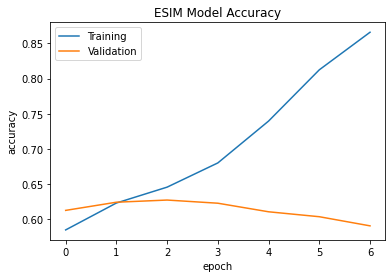

In [0]:
plt.figure(1)
plt.plot(esim_model_.history['accuracy'])
plt.plot(esim_model_.history['val_accuracy'])
plt.title('ESIM Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show();

**Plotting loss function of the model**

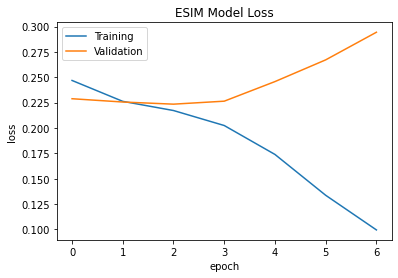

In [0]:
plt.figure(2)
plt.plot(esim_model_.history['loss'])
plt.plot(esim_model_.history['val_loss'])
plt.title('ESIM Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show();

**Test Score**

In [0]:
bestmodel = '/content/gdrive/My Drive/Colab Notebooks/saved_models_prat/adam-e3-bs-64-finalmodel-03-0.22350.hdf5'
esim_model.load_weights(bestmodel)

In [0]:
score = esim_model.evaluate(x_test,
                            y_test,
                            batch_size=BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

12000/12000 [==============================] - 25s 2ms/step
Test loss: 0.22458882780869802
Test accuracy: 0.6242499947547913


In [0]:
from sklearn.metrics import classification_report

In [0]:
y_pred = esim_model.predict(x_test)
y_pred = [0 if x < 0.5 else 1 for x in y_pred]
y_test_1hot = [0 if not x else 1 for x in y_test]
print(classification_report(y_test_1hot, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.60      0.61      5966
           1       0.62      0.65      0.63      6034

    accuracy                           0.62     12000
   macro avg       0.62      0.62      0.62     12000
weighted avg       0.62      0.62      0.62     12000

